In [1]:
# model3 test

In [1]:
import os
import time
import numpy as np
from PIL import Image
from torch.utils.data.dataset import Dataset
from tqdm import tqdm
from torchvision import transforms
from torchvision import models
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torch import nn
from torch.utils.data.dataloader import DataLoader
from matplotlib import pyplot as plt
from numpy import printoptions
import requests
import tarfile
import random
import json
from shutil import copyfile
from torchsummary import summary 

c:\Users\NGN\anaconda3\envs\auto_tagging\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Fix all seeds to make experiments reproducible
torch.manual_seed(2024)
torch.cuda.manual_seed(2024)
np.random.seed(2024)
random.seed(2024)
torch.backends.cudnn.deterministic = True

In [3]:
# Simple dataloader and label binarization, 
# that is converting test labels into binary arrays of length 71 
# (number of classes) with 1 in places of applicable labels).
class MpstDataset(Dataset):
    def __init__(self, data_path, anno_path, transforms, split_type):
        self.transforms = transforms
        self.split_type= split_type
        with open(anno_path) as fp:
            json_data = json.load(fp)
        samples = json_data['samples']
        self.classes = json_data['labels']

        self.imgs = [] # 이미지 이름
        self.annos = [] # 태그 이름
        self.data_path = data_path
        print('loading', anno_path)
        for sample in samples:
            self.imgs.append(sample['image_name'])
            self.annos.append(sample['image_labels'])
        for item_id in range(len(self.annos)):
            item = self.annos[item_id]
            vector = [cls in item for cls in self.classes]
            self.annos[item_id] = np.array(vector, dtype=float) # labeling one-hot encoding

    def __getitem__(self, item):
        anno = self.annos[item]    
        img_path = os.path.join(self.data_path, self.split_type, self.imgs[item])
        img_path += '.png'
        img = Image.open(img_path).convert('RGB')
        if self.transforms is not None:
            img = self.transforms(img)
        return img, anno

    def __len__(self):
        return len(self.imgs)

loading E:\NRF_2022\MDPI\Extracted_Data\new_stft_2024\val\val.json
loading E:\NRF_2022\MDPI\Extracted_Data\new_stft_2024\train\train.json


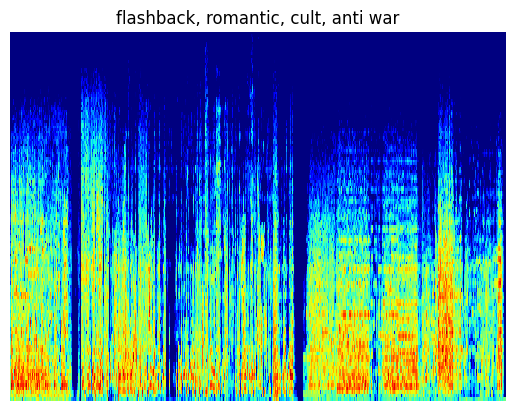

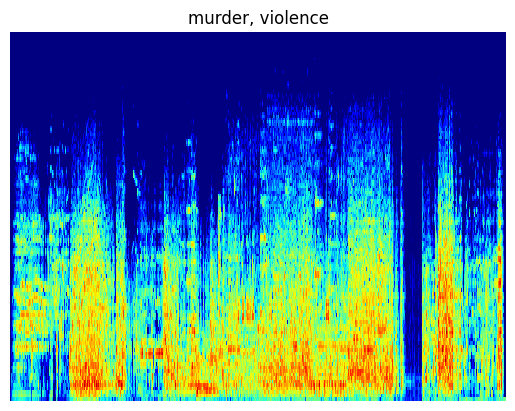

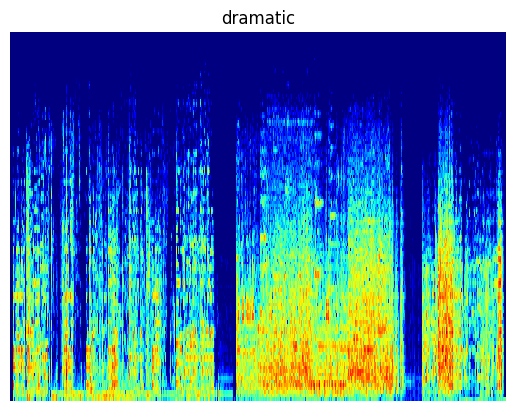

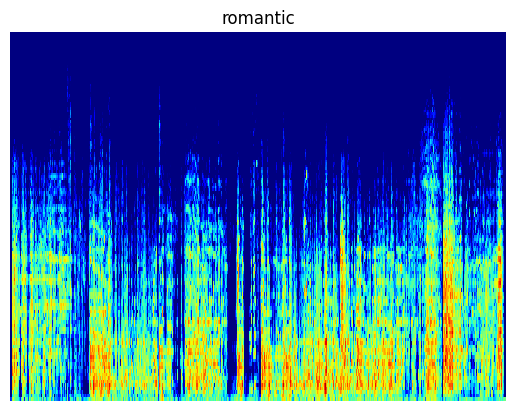

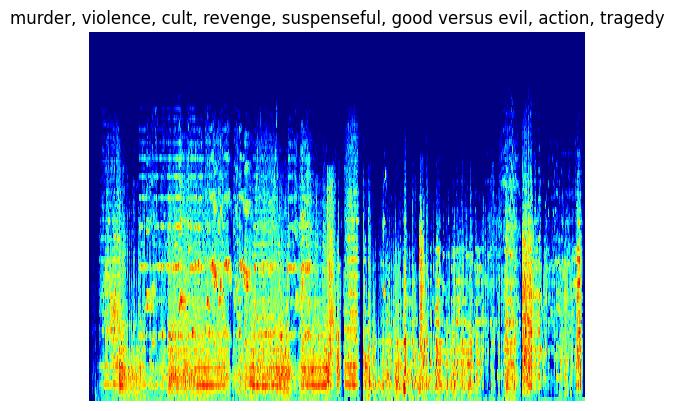

In [4]:
# Let's take a look at the data we have. To do it we need to load the dataset without augmentations.
img_folder='E:\\NRF_2022\\MDPI\\Extracted_Data\\new_stft_2024'
split_train='train'
split_val='val'
dataset_val = MpstDataset(img_folder, os.path.join(img_folder, 'val', 'val.json'), None, split_val)
dataset_train = MpstDataset(img_folder, os.path.join(img_folder, 'train', 'train.json'), None, split_train)

# A simple function for visualization.
def show_sample(img, binary_img_labels):
    # Convert the binary labels back to the text representation.    
    img_labels = np.array(dataset_val.classes)[np.argwhere(binary_img_labels > 0)[:, 0]]
    plt.imshow(img)
    plt.title("{}".format(', '.join(img_labels)))
    plt.axis('off')
    plt.show()

for sample_id in range(5):
    show_sample(*dataset_val[sample_id])

Label distribution (count, class name): [(0, 'christian film'), (0, 'non fiction'), (1, 'western'), (1, 'autobiographical'), (3, 'thought-provoking'), (3, 'magical realism'), (5, 'adult comedy'), (5, 'suicidal'), (6, 'historical fiction'), (6, 'brainwashing'), (6, 'whimsical'), (6, 'blaxploitation'), (7, 'clever'), (8, 'allegory'), (8, 'feel-good'), (9, 'plot twist'), (9, 'intrigue'), (9, 'pornographic'), (9, 'grindhouse film'), (10, 'queer'), (11, 'anti war'), (11, 'claustrophobic'), (12, 'sentimental'), (12, 'cute'), (12, 'haunting'), (12, 'comic'), (13, 'philosophical'), (13, 'avant garde'), (13, 'home movie'), (15, 'bleak'), (15, 'depressing'), (15, 'realism'), (15, 'alternate history'), (16, 'psychological'), (17, 'storytelling'), (17, 'inspiring'), (18, 'stupid'), (19, 'melodrama'), (20, 'alternate reality'), (21, 'cruelty'), (21, 'absurd'), (26, 'paranormal'), (28, 'sci-fi'), (28, 'historical'), (29, 'prank'), (40, 'atmospheric'), (41, 'boring'), (43, 'fantasy'), (43, 'gothic'),

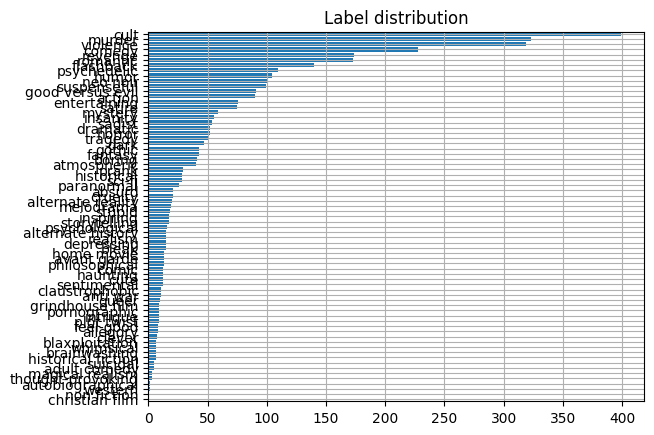

In [5]:
# Calculate label distribution for the entire dataset (train + val)
samples = dataset_val.annos + dataset_train.annos
samples = np.array(samples)
with printoptions(precision=3, suppress=True):
    class_counts = np.sum(samples, axis=0)
    # Sort labels according to their frequency in the dataset.
    sorted_ids = np.array([i[0] for i in sorted(enumerate(class_counts), key=lambda x: x[1])], dtype=int)
    print('Label distribution (count, class name):', list(zip(class_counts[sorted_ids].astype(int), np.array(dataset_val.classes)[sorted_ids])))
    plt.barh(range(len(dataset_val.classes)), width=class_counts[sorted_ids])
    plt.yticks(range(len(dataset_val.classes)), np.array(dataset_val.classes)[sorted_ids])
    plt.gca().margins(y=0)
    plt.grid()
    plt.title('Label distribution')
    plt.show()

In [6]:
# Use the torchvision's implementation of ResNeXt, 
# but add FC layer for a different number of classes (71)
# and a Sigmoid instead of a default Softmax.
class Resnet50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

In [7]:
# Use threshold to define predicted labels 
# and invoke sklearn's metrics with different averaging strategies.
def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
            
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
            
            'weighted/precision': precision_score(y_true=target, y_pred=pred, average='weighted'),
            'weighted/recall': recall_score(y_true=target, y_pred=pred, average='weighted'),
            'weighted/f1': f1_score(y_true=target, y_pred=pred, average='weighted'),
            }

In [8]:
# Initialize the training parameters.
num_workers = 0 # 8 # Number of CPU processes for data preprocessing
lr = 1e-4 # Learning rate
batch_size = 32
save_freq = 1 # Save checkpoint frequency (epochs)
val_freq = 200 # Test model frequency (iterations)
max_epoch_number = 100 # Number of epochs for training 
# Note: on the small subset of data overfitting happens after 30-35 epochs

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

device = torch.device('cuda')
# Save path for checkpoints
save_path = './checkpoints/test7'
# Save path for logs
logdir = './logs/test7'

# Run tensorboard
%load_ext tensorboard
%tensorboard --logdir {logdir}

Reusing TensorBoard on port 6006 (pid 16624), started 1:20:58 ago. (Use '!kill 16624' to kill it.)

In [9]:
# Here is an auxiliary function for checkpoint saving.
def checkpoint_save(model, save_path, epoch):
    f = os.path.join(save_path, 'checkpoint-{:06d}.pth'.format(epoch)) # checkpoint-000029.pth
    if 'module' in dir(model):
        torch.save(model.module.state_dict(), f)
    else:
        torch.save(model.state_dict(), f)
    print('saved checkpoint:', f)

In [10]:
# val preprocessing
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
print(tuple(np.array(np.array(mean)*255).tolist()))

# Train preprocessing
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(),
    # transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.5, 1.5),
    #                         shear=None, 
    #                         # resample=False, 
    #                         # fillcolor=tuple(np.array(np.array(mean)*255).astype(int).tolist())),
    #                         fill=tuple(np.array(np.array(mean)*255).astype(int).tolist())),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

(123.675, 116.28, 103.53)


In [11]:
img_folder='E:\\NRF_2022\\MDPI\\Extracted_Data\\new_stft_2024'
split_train='train'
split_val='val'

# Initialize the dataloaders for training.
val_annotations = os.path.join(img_folder, 'val', 'val.json')
train_annotations = os.path.join(img_folder, 'train', 'train.json')

val_dataset = MpstDataset(img_folder, val_annotations, val_transform, split_val)
train_dataset = MpstDataset(img_folder, train_annotations, train_transform, split_train)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True,
                              # drop_last=True
                              )
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)

num_train_batches = int(np.ceil(len(train_dataset) / batch_size))

loading E:\NRF_2022\MDPI\Extracted_Data\new_stft_2024\val\val.json
loading E:\NRF_2022\MDPI\Extracted_Data\new_stft_2024\train\train.json


In [12]:
def train(model, optimizer, train_loader, val_loader, scheduler, device, logger):
    model.to(device)
    criterion = nn.BCELoss().to(device)
    
    
    best_val_acc = 0
    best_val_loss = 1
    best_model = None
    
    iteration = 0
    best_epoch = 0 
    for epoch in range(1, max_epoch_number+1):
        
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels.type(torch.float))
            batch_loss_value = loss.item()
            
            loss.backward()
            optimizer.step()
            # tensorboard
            logger.add_scalar('train_loss', batch_loss_value, iteration) # iteration 마다 train_loss를 기록
            train_loss.append(batch_loss_value) # 
            iteration+=1
            
        # epoch 마다 검증            
        _val_loss, _val_acc = validation(model, criterion, val_loader, device, logger, iteration)
        
       
        logger.add_scalar('val_loss/epoch' ,  _val_loss, epoch)
        logger.add_scalar('val_acc/epoch' , _val_acc, epoch)

        
        _train_loss = np.mean(train_loss)
        logger.add_scalar('per_iter_batch_mean_train_loss', _train_loss, iteration) 
        logger.add_scalar('per_epoch_batch_mean_train_loss', _train_loss, epoch) 
        
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] \
              Val Loss : [{_val_loss:.5f}] Val ACC : [{_val_acc:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_acc)
            
        # if best_val_acc < _val_acc:
            # best_val_acc = _val_acc
        if best_val_loss > _val_loss: # 현재 _val_loss
            best_val_loss = _val_loss
            best_model = model
            best_epoch = epoch
    
    return best_model, best_epoch

def validation(model, criterion, val_loader, device, logger, iteration):
    model.eval()
    val_loss = []
    val_acc = []
    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            probs = model(imgs)
            
            loss = criterion(probs, labels.type(torch.float)) # bce loss
            
            probs  = probs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            preds = probs > 0.5
            batch_acc = (labels == preds).mean()
            
            val_acc.append(batch_acc)
            val_loss.append(loss.item())
            # logger.add_scalar('val_acc/iter' ,  batch_acc, iteration)
            # logger.add_scalar('val_loss/iter' , loss.item(), iteration)

        
        _val_loss = np.mean(val_loss) # val_loader batch마다 기록
        _val_acc = np.mean(val_acc)
    
    return _val_loss, _val_acc

In [13]:
# Tensoboard logger
logger = SummaryWriter(logdir)

In [14]:
# Initialize the model
model = Resnet50(len(train_dataset.classes))
model = model.to(device)
# print(summary(model, (3, 256, 256), batch_size=32))
# print(model)

# Switch model to the training mode and move it to GPU.
model.train()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

# If more than one GPU is available we can use both to speed up the training.
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

os.makedirs(save_path, exist_ok=True)

# Loss function
criterion = nn.BCELoss() # BinaryCrossEntropy Loss
# criterion = nn.MultiLabelSoftMarginLoss()


c:\Users\NGN\anaconda3\envs\auto_tagging\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\NGN\anaconda3\envs\auto_tagging\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
infer_model, b_epoch = train(model, optimizer, train_loader, val_loader, scheduler, device, logger=logger)

100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [1], Train Loss : [0.43139]               Val Loss : [0.23803] Val ACC : [0.93719]


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Epoch [2], Train Loss : [0.20540]               Val Loss : [0.19214] Val ACC : [0.93794]


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch [3], Train Loss : [0.17519]               Val Loss : [0.19544] Val ACC : [0.93788]


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [4], Train Loss : [0.15963]               Val Loss : [0.20607] Val ACC : [0.93857]


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Epoch [5], Train Loss : [0.14667]               Val Loss : [0.20572] Val ACC : [0.93719]


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch [6], Train Loss : [0.13402]               Val Loss : [0.20413] Val ACC : [0.93775]


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


Epoch [7], Train Loss : [0.12064]               Val Loss : [0.20991] Val ACC : [0.93662]
Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Epoch [8], Train Loss : [0.10901]               Val Loss : [0.20264] Val ACC : [0.93744]


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Epoch [9], Train Loss : [0.09940]               Val Loss : [0.20618] Val ACC : [0.93750]


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch [10], Train Loss : [0.09269]               Val Loss : [0.20843] Val ACC : [0.93800]
Epoch 00010: reducing learning rate of group 0 to 2.5000e-05.


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [11], Train Loss : [0.08672]               Val Loss : [0.21015] Val ACC : [0.93712]


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch [12], Train Loss : [0.08318]               Val Loss : [0.21116] Val ACC : [0.93756]


100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


Epoch [13], Train Loss : [0.07998]               Val Loss : [0.21227] Val ACC : [0.93775]
Epoch 00013: reducing learning rate of group 0 to 1.2500e-05.


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [14], Train Loss : [0.07723]               Val Loss : [0.21148] Val ACC : [0.93813]


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


Epoch [15], Train Loss : [0.07623]               Val Loss : [0.21246] Val ACC : [0.93781]


100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


Epoch [16], Train Loss : [0.07440]               Val Loss : [0.21246] Val ACC : [0.93763]
Epoch 00016: reducing learning rate of group 0 to 6.2500e-06.


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [17], Train Loss : [0.07290]               Val Loss : [0.21366] Val ACC : [0.93851]


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Epoch [18], Train Loss : [0.07254]               Val Loss : [0.21178] Val ACC : [0.93719]


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [19], Train Loss : [0.07171]               Val Loss : [0.21381] Val ACC : [0.93800]
Epoch 00019: reducing learning rate of group 0 to 3.1250e-06.


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [20], Train Loss : [0.07121]               Val Loss : [0.21381] Val ACC : [0.93756]


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Epoch [21], Train Loss : [0.07073]               Val Loss : [0.21479] Val ACC : [0.93750]


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Epoch [22], Train Loss : [0.07054]               Val Loss : [0.21443] Val ACC : [0.93763]
Epoch 00022: reducing learning rate of group 0 to 1.5625e-06.


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [23], Train Loss : [0.06981]               Val Loss : [0.21456] Val ACC : [0.93731]


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [24], Train Loss : [0.06970]               Val Loss : [0.21296] Val ACC : [0.93737]


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [25], Train Loss : [0.06939]               Val Loss : [0.21306] Val ACC : [0.93731]
Epoch 00025: reducing learning rate of group 0 to 7.8125e-07.


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [26], Train Loss : [0.06952]               Val Loss : [0.21337] Val ACC : [0.93737]


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [27], Train Loss : [0.06937]               Val Loss : [0.21316] Val ACC : [0.93744]


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [28], Train Loss : [0.06907]               Val Loss : [0.21410] Val ACC : [0.93750]
Epoch 00028: reducing learning rate of group 0 to 3.9063e-07.


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Epoch [29], Train Loss : [0.06916]               Val Loss : [0.21476] Val ACC : [0.93731]


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [30], Train Loss : [0.06894]               Val Loss : [0.21507] Val ACC : [0.93731]


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [31], Train Loss : [0.06853]               Val Loss : [0.21420] Val ACC : [0.93725]
Epoch 00031: reducing learning rate of group 0 to 1.9531e-07.


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


Epoch [32], Train Loss : [0.06877]               Val Loss : [0.21504] Val ACC : [0.93712]


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [33], Train Loss : [0.06869]               Val Loss : [0.21484] Val ACC : [0.93725]


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [34], Train Loss : [0.06896]               Val Loss : [0.21440] Val ACC : [0.93700]
Epoch 00034: reducing learning rate of group 0 to 9.7656e-08.


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


Epoch [35], Train Loss : [0.06889]               Val Loss : [0.21386] Val ACC : [0.93719]


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [36], Train Loss : [0.06930]               Val Loss : [0.21450] Val ACC : [0.93712]


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [37], Train Loss : [0.06939]               Val Loss : [0.21515] Val ACC : [0.93737]
Epoch 00037: reducing learning rate of group 0 to 4.8828e-08.


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [38], Train Loss : [0.06863]               Val Loss : [0.21405] Val ACC : [0.93725]


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Epoch [39], Train Loss : [0.06907]               Val Loss : [0.21354] Val ACC : [0.93756]


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [40], Train Loss : [0.06936]               Val Loss : [0.21343] Val ACC : [0.93712]
Epoch 00040: reducing learning rate of group 0 to 2.4414e-08.


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Epoch [41], Train Loss : [0.06920]               Val Loss : [0.21409] Val ACC : [0.93794]


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Epoch [42], Train Loss : [0.06905]               Val Loss : [0.21514] Val ACC : [0.93775]


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Epoch [43], Train Loss : [0.06890]               Val Loss : [0.21543] Val ACC : [0.93750]
Epoch 00043: reducing learning rate of group 0 to 1.2207e-08.


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Epoch [44], Train Loss : [0.06894]               Val Loss : [0.21486] Val ACC : [0.93825]


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Epoch [45], Train Loss : [0.06900]               Val Loss : [0.21424] Val ACC : [0.93775]


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [46], Train Loss : [0.06869]               Val Loss : [0.21513] Val ACC : [0.93731]


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Epoch [47], Train Loss : [0.06865]               Val Loss : [0.21582] Val ACC : [0.93725]


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Epoch [48], Train Loss : [0.06913]               Val Loss : [0.21432] Val ACC : [0.93731]


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Epoch [49], Train Loss : [0.06984]               Val Loss : [0.21461] Val ACC : [0.93744]


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [50], Train Loss : [0.06873]               Val Loss : [0.21591] Val ACC : [0.93794]


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


Epoch [51], Train Loss : [0.06923]               Val Loss : [0.21450] Val ACC : [0.93725]


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Epoch [52], Train Loss : [0.06945]               Val Loss : [0.21606] Val ACC : [0.93756]


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [53], Train Loss : [0.06825]               Val Loss : [0.21489] Val ACC : [0.93775]


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Epoch [54], Train Loss : [0.06843]               Val Loss : [0.21498] Val ACC : [0.93719]


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Epoch [55], Train Loss : [0.06866]               Val Loss : [0.21434] Val ACC : [0.93756]


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [56], Train Loss : [0.06941]               Val Loss : [0.21443] Val ACC : [0.93712]


100%|██████████| 7/7 [00:09<00:00,  1.35s/it]


Epoch [57], Train Loss : [0.06873]               Val Loss : [0.21439] Val ACC : [0.93731]


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


Epoch [58], Train Loss : [0.06882]               Val Loss : [0.21495] Val ACC : [0.93763]


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch [59], Train Loss : [0.06890]               Val Loss : [0.21394] Val ACC : [0.93744]


100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


Epoch [60], Train Loss : [0.06951]               Val Loss : [0.21602] Val ACC : [0.93725]


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch [61], Train Loss : [0.06926]               Val Loss : [0.21425] Val ACC : [0.93731]


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch [62], Train Loss : [0.06904]               Val Loss : [0.21564] Val ACC : [0.93788]


100%|██████████| 7/7 [00:09<00:00,  1.41s/it]


Epoch [63], Train Loss : [0.06902]               Val Loss : [0.21457] Val ACC : [0.93763]


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch [64], Train Loss : [0.06894]               Val Loss : [0.21402] Val ACC : [0.93719]


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch [65], Train Loss : [0.06901]               Val Loss : [0.21485] Val ACC : [0.93769]


100%|██████████| 7/7 [00:09<00:00,  1.39s/it]


Epoch [66], Train Loss : [0.06910]               Val Loss : [0.21490] Val ACC : [0.93737]


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch [67], Train Loss : [0.06894]               Val Loss : [0.21358] Val ACC : [0.93725]


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch [68], Train Loss : [0.06865]               Val Loss : [0.21437] Val ACC : [0.93712]


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch [69], Train Loss : [0.06832]               Val Loss : [0.21432] Val ACC : [0.93706]


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch [70], Train Loss : [0.06838]               Val Loss : [0.21388] Val ACC : [0.93725]


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch [71], Train Loss : [0.06922]               Val Loss : [0.21381] Val ACC : [0.93687]


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch [72], Train Loss : [0.06919]               Val Loss : [0.21598] Val ACC : [0.93788]


100%|██████████| 7/7 [00:09<00:00,  1.39s/it]


Epoch [73], Train Loss : [0.06820]               Val Loss : [0.21502] Val ACC : [0.93731]


100%|██████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch [74], Train Loss : [0.06881]               Val Loss : [0.21409] Val ACC : [0.93731]


100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


Epoch [75], Train Loss : [0.06913]               Val Loss : [0.21512] Val ACC : [0.93819]


100%|██████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch [76], Train Loss : [0.06900]               Val Loss : [0.21540] Val ACC : [0.93706]


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


Epoch [77], Train Loss : [0.06887]               Val Loss : [0.21471] Val ACC : [0.93712]


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch [78], Train Loss : [0.06885]               Val Loss : [0.21560] Val ACC : [0.93769]


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch [79], Train Loss : [0.06853]               Val Loss : [0.21472] Val ACC : [0.93775]


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch [80], Train Loss : [0.06855]               Val Loss : [0.21329] Val ACC : [0.93731]


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch [81], Train Loss : [0.06886]               Val Loss : [0.21404] Val ACC : [0.93700]


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch [82], Train Loss : [0.06854]               Val Loss : [0.21493] Val ACC : [0.93719]


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch [83], Train Loss : [0.06915]               Val Loss : [0.21496] Val ACC : [0.93763]


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch [84], Train Loss : [0.06970]               Val Loss : [0.21541] Val ACC : [0.93788]


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch [85], Train Loss : [0.06863]               Val Loss : [0.21514] Val ACC : [0.93800]


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch [86], Train Loss : [0.06931]               Val Loss : [0.21615] Val ACC : [0.93731]


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch [87], Train Loss : [0.06875]               Val Loss : [0.21486] Val ACC : [0.93781]


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch [88], Train Loss : [0.06916]               Val Loss : [0.21544] Val ACC : [0.93737]


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch [89], Train Loss : [0.06880]               Val Loss : [0.21453] Val ACC : [0.93750]


100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


Epoch [90], Train Loss : [0.06845]               Val Loss : [0.21355] Val ACC : [0.93725]


100%|██████████| 7/7 [00:09<00:00,  1.33s/it]


Epoch [91], Train Loss : [0.06905]               Val Loss : [0.21486] Val ACC : [0.93851]


100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


Epoch [92], Train Loss : [0.06941]               Val Loss : [0.21487] Val ACC : [0.93719]


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch [93], Train Loss : [0.06860]               Val Loss : [0.21495] Val ACC : [0.93719]


100%|██████████| 7/7 [00:10<00:00,  1.54s/it]


Epoch [94], Train Loss : [0.06908]               Val Loss : [0.21477] Val ACC : [0.93763]


100%|██████████| 7/7 [00:10<00:00,  1.55s/it]


Epoch [95], Train Loss : [0.06884]               Val Loss : [0.21426] Val ACC : [0.93712]


100%|██████████| 7/7 [00:11<00:00,  1.58s/it]


Epoch [96], Train Loss : [0.06852]               Val Loss : [0.21432] Val ACC : [0.93737]


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch [97], Train Loss : [0.06906]               Val Loss : [0.21406] Val ACC : [0.93744]


100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch [98], Train Loss : [0.06902]               Val Loss : [0.21483] Val ACC : [0.93706]


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch [99], Train Loss : [0.06872]               Val Loss : [0.21395] Val ACC : [0.93737]


100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

Epoch [100], Train Loss : [0.06948]               Val Loss : [0.21431] Val ACC : [0.93737]


In [16]:
checkpoint_save(infer_model, save_path, b_epoch)

saved checkpoint: ./checkpoints/test7\checkpoint-000001.pth


In [17]:
print(b_epoch)

1


In [ ]:
# Run inference on the test data
# test preprocessing
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
split_test='test'
img_folder='E:\\NRF_2022\\MDPI\\Extracted_Data\\new_stft_2024'
test_annotations = os.path.join(img_folder, 'test', 'test.json')
test_dataset = MpstDataset(img_folder, test_annotations, test_transform, split_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, 
                                num_workers=num_workers)




In [ ]:
print(test_dataset[0])

In [ ]:
print(test_dataloader)

In [ ]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    predictions=[]
    with torch.no_grad():
        for imgs, labels in tqdm(iter(test_loader)):
            imgs=imgs.float().to(device)
            
            probs=model(imgs)
            
            probs=probs.cpu().detach().numpy()
            preds=probs>0.5
            preds=preds.astype(int)
            predictions+=preds.tolist()
    return predictions
            

In [ ]:
print(len(test_dataset))

In [ ]:
preds=inference(model, test_dataloader, device)

In [ ]:
print(preds)
print(len(preds))

In [ ]:
import pandas as pd
submit=pd.read_csv('./result_sample/test6/test6.csv')
submit.iloc[:,1:] = preds
submit.head()

In [ ]:
import json

item_list=[]
    
for sample_id in range(len(test_dataset)):
    test_img, test_labels = test_dataset[sample_id]
    test_img_path = os.path.join(img_folder, 'test', test_dataset.imgs[sample_id])
    test_img_path+='.png'
    with torch.no_grad():
        raw_pred = model(test_img.unsqueeze(0).to(device)).cpu().numpy()[0]
        raw_pred = np.array(raw_pred > 0.5, dtype=float)


    predicted_labels = np.array(test_dataset.classes)[np.argwhere(raw_pred > 0)[:, 0]]
    if not len(predicted_labels):
        predicted_labels = np.array(['no pred']) # ['no predictions']
    img_labels = np.array(test_dataset.classes)[np.argwhere(test_labels > 0)[:, 0]]
    
    plt.imshow(Image.open(test_img_path).convert('RGB'))
    plt.title("movie: {} \nPredicted labels: {} \nGT labels: {}".format(test_dataset.imgs[sample_id],', '.join(predicted_labels), ', '.join(img_labels)))
    plt.axis('off')
    plt.show()
    
    # json 파일 쓰기
    item={'imdb_id': test_dataset.imgs[sample_id],
          'gt_labels': predicted_labels.tolist(),
          'predicted_labels': img_labels.tolist()
          }
    item_list.append(item)
    
with open('./result_sample/test6/test6.json', 'w') as f:
    json.dump(item_list, f, indent=3)